### Importing libraries

In [257]:
import pandas as pd
import tensorflow as tf

### Configuring hardware

In [258]:
physical_devices = tf.config.list_physical_devices()

print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [259]:
tf.config.set_visible_devices(physical_devices[1], 'GPU')

### Loading data

##### Processed dataset with pre-selecter features (by Random Forest)

In [260]:
# data_train = pd.read_csv('data/processed/train_meaningfull.csv')
# data_test = pd.read_csv('data/processed/test_meaningfull.csv')

##### Raw dataset with (>500 features)

In [261]:
data_train = pd.read_csv('data/raw/train.csv')
data_test = pd.read_csv('data/raw/test.csv')

##### Processing data

In [262]:
X_train = data_train.drop('Activity', axis='columns')
y_train = data_train['Activity']
y_train_encoded = pd.get_dummies(y_train)

In [263]:
X_test = data_test.drop('Activity', axis='columns')
y_test = data_test['Activity']
y_test_encoded = pd.get_dummies(y_test)

### Build model

In [264]:
from tensorflow import keras
from keras import regularizers
from keras import layers

regularizer = regularizers.l2(l=0.01)

model = keras.Sequential(
  [
    layers.Input(X_train.shape[-1]),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.4),
    layers.Dense(6, activation="sigmoid"),
  ]
)
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_109 (Dense)           (None, 128)               72064     
                                                                 
 dropout_48 (Dropout)        (None, 128)               0         
                                                                 
 dense_110 (Dense)           (None, 256)               33024     
                                                                 
 dropout_49 (Dropout)        (None, 256)               0         
                                                                 
 dense_111 (Dense)           (None, 128)               32896     
                                                                 
 dropout_50 (Dropout)        (None, 128)               0         
                                                                 
 dense_112 (Dense)           (None, 6)               

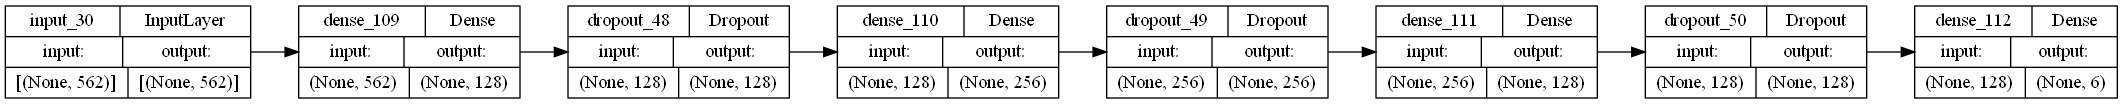

In [265]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [266]:
optimizer = keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics='accuracy')

In [267]:
model.fit(
  X_train,
  y_train_encoded,
  batch_size=1000,
  epochs=100,
  verbose=1,
  validation_split=0.3
)

Epoch 1/100
6/6 [==============================] - 1s 61ms/step - loss: 7.1092 - accuracy: 0.2534 - val_loss: 6.3926 - val_accuracy: 0.3577
Epoch 2/100
6/6 [==============================] - 0s 27ms/step - loss: 6.2173 - accuracy: 0.3970 - val_loss: 5.6021 - val_accuracy: 0.4374
Epoch 3/100
6/6 [==============================] - 0s 33ms/step - loss: 5.5259 - accuracy: 0.4592 - val_loss: 4.9556 - val_accuracy: 0.6999
Epoch 4/100
6/6 [==============================] - 0s 19ms/step - loss: 4.9291 - accuracy: 0.5309 - val_loss: 4.4331 - val_accuracy: 0.8200
Epoch 5/100
6/6 [==============================] - 0s 18ms/step - loss: 4.4102 - accuracy: 0.5987 - val_loss: 3.9745 - val_accuracy: 0.8005
Epoch 6/100
6/6 [==============================] - 0s 17ms/step - loss: 3.9181 - accuracy: 0.6832 - val_loss: 3.5243 - val_accuracy: 0.8672
Epoch 7/100
6/6 [==============================] - 0s 17ms/step - loss: 3.5129 - accuracy: 0.7190 - val_loss: 3.1975 - val_accuracy: 0.8640
Epoch 8/100
6/6 [===

In [268]:
score = model.evaluate(X_test, y_test_encoded)[1]

print(score)

93/93 [==============================] - 0s 3ms/step - loss: 0.4682 - accuracy: 0.9030
0.9029521346092224
